In [32]:
import json
import numpy as np
import os
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from math import ceil
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

### General

In [33]:
DATA_SET_FILE_NAME = 'News_Category_Dataset_v2.json'
CHECKPOINT_PATH = '/home/ns/Dokumenty/UPC/dl/lab2/project_news/checkpoint'

### Data-set

In [34]:
TEST_SET_SIZE = 0.2

### Vocab

In [35]:
VOCAB_SIZE = 8126
EMB_SIZE = 10

# VOCAB_SIZE = 719
# EMB_SIZE = 100
TOKENIZER_MODE = 'count'

### Network

In [36]:
REC_TYPE = 'LSTM'
N_NEURONS = 8
N_LAYERS = 1
OPTIMIZER = Adam(lr=0.001, decay=0.0001)
DROPOUT = 0.0

### Training

In [37]:
EPOCHS = 2
BATCH_SIZE = 256
VERBOSE = True

## Loading data-set

In [38]:
file = open(DATA_SET_FILE_NAME, 'r')
news = []
for line in file:
    news.append(json.loads(line))

### Shuffle ds

In [39]:
np.random.shuffle(news)

In [40]:
news[:2]

[{'authors': 'Ryan Buxton',
  'category': 'ENTERTAINMENT',
  'date': '2014-12-03',
  'headline': "Steven Spielberg's T-Rex Impression Stinks",
  'link': 'https://www.huffingtonpost.com/entry/jurassic-park-steven-spielberg-dinosaur-impression_n_6262356.html',
  'short_description': ''},
 {'authors': '',
  'category': 'TRAVEL',
  'date': '2012-08-31',
  'headline': '5 Labor Day Destinations To Avoid (PHOTOS)',
  'link': 'https://www.huffingtonpost.com/entry/5-labor-day-destinations_us_5b9c35eae4b03a1dcc7d1e4b',
  'short_description': "Getting away is good, but exchanging one type of stress for another doesn't solve anything. The crowds in Napa, on Cape Cod"}]

## Preprocessing data-set

### Preprocess data and extract corpus

In [41]:
to_merge = {
    'CULTURE & ARTS' : 'ARTS',
    'EDUCATION' : 'COLLEGE',
    'ARTS & CULTURE' : 'ARTS' 
}

news_joined = []
labels = []

for sample in news:
    cat = sample['category']
    for key in to_merge.keys():
        if cat == key:
            cat = to_merge[key]
            break
    
    text = sample['headline'] + ' ' + sample['short_description']
    
    news_joined.append(text)
    labels.append(cat)

### Prepare the data

In [42]:
news_joined[:5]

["Steven Spielberg's T-Rex Impression Stinks ",
 "5 Labor Day Destinations To Avoid (PHOTOS) Getting away is good, but exchanging one type of stress for another doesn't solve anything. The crowds in Napa, on Cape Cod",
 'StepMill Glute-Sculpting Workout Rather than giving up your tight buns for cinnamon buns, try switching up your typical glute routine by adding in this StepMill glute-sculpting workout.',
 'John Legend Speaks Out Against Trump\'s Syrian Refugee And Travel Ban "I want to specifically tonight reject his vision and affirm that America has to be better than that.”',
 'Elizabeth Warren: Donald Trump\'s Presidency \'Feels Like Dog Years\' "Like he’s been there forever!"']

### Train tokenizer

In [43]:
vocab_size = VOCAB_SIZE
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(news_joined)

### Tokenize the sequence

In [44]:
encoded_tweets_np = tokenizer.texts_to_sequences(news_joined)
encoded_tweets = pad_sequences(encoded_tweets_np)
print('Shape: ', encoded_tweets.shape)

Shape:  (200853, 226)


In [45]:
pads = []
for tweet in encoded_tweets:
    s = 0
    for x in tweet:
        if x == 0:
            s +=1
    pads.append(s/len(tweet))

In [49]:
encoded_tweets_np

[[3491, 1025, 5081, 3505],
 [137,
  1161,
  62,
  1942,
  2,
  778,
  58,
  214,
  284,
  7,
  113,
  26,
  39,
  1562,
  4,
  409,
  8,
  195,
  224,
  2875,
  571,
  1,
  4982,
  6,
  10,
  5445],
 [1326,
  701,
  64,
  588,
  47,
  18,
  3904,
  8,
  7130,
  394,
  47,
  18,
  3162,
  1784,
  35,
  3193,
  6,
  16,
  1326],
 [391,
  2260,
  2295,
  41,
  173,
  183,
  1680,
  2296,
  5,
  260,
  695,
  13,
  89,
  2,
  3492,
  2639,
  4688,
  44,
  2180,
  5,
  9,
  219,
  38,
  2,
  17,
  155,
  64,
  9,
  186],
 [1582, 1952, 97, 183, 2031, 57, 590, 57, 2573, 75, 74, 1439],
 [14, 85, 17, 54, 2, 1889, 41, 18, 279, 1496],
 [679,
  609,
  5,
  1098,
  2102,
  89,
  3,
  397,
  12,
  1,
  705,
  410,
  2,
  244,
  100,
  1,
  2236,
  15,
  421,
  2,
  943,
  31,
  47,
  37,
  136,
  495,
  10,
  108,
  109,
  339,
  8,
  3,
  3650,
  1776,
  1212,
  4412,
  6,
  3317],
 [5, 58, 2685, 4959, 9, 4497, 309, 79, 15, 24, 3, 5376, 7828],
 [82,
  618,
  833,
  29,
  660,
  5,
  1620,
  90,
  1

### Remove 0 sequences

In [26]:
non_zero = np.sum(encoded_tweets, axis=1) > 0
enc_non_zero = encoded_tweets[non_zero]
labels_clr = np.matrix(labels).transpose()[non_zero]
print('Shape after deleting non-informative:', enc_non_zero.shape)

Shape after deleting non-informative: (199327, 110)


### Labels to int

In [44]:
enc_int = LabelEncoder()
labels_int = enc_int.fit_transform(labels_clr).reshape(-1, 1)

/home/ns/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### One-hot encode the labels

In [48]:
enc = OneHotEncoder(handle_unknown='error')
labels_one_hot = enc.fit_transform(labels_int).toarray()
labels_one_hot

/home/ns/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Divide data-set into train and test

In [16]:
ds_size = labels_clr.shape[0]
split = ceil(ds_size * TEST_SET_SIZE)
x_train, x_test = enc_non_zero[split:], enc_non_zero[:split]
y_train, y_test = labels_one_hot[split:], labels_one_hot[:split]

print('x_train:', x_train.shape,
     '\nx_test:', x_test.shape,
     '\n\ny_train:', y_train.shape,
     '\ny_test:', y_test.shape)

x_train: (159461, 110) 
x_test: (39866, 110) 

y_train: (159461, 38) 
y_test: (39866, 38)


### Build the model

In [27]:
def get_model(emb_input_size, emb_output_size, 
              classes, optimizer, units, rec_type='LSTM', layers=1, rec_dropout=0):
    model = Sequential()
    
    embedding_layer = Embedding(
        input_dim=emb_input_size,
        output_dim=emb_output_size
    )
    
    model.add(embedding_layer)
    
    rec_layer = LSTM if rec_type == 'LSTM' else GRU
    
    if layers == 1:
        model.add(rec_layer(units, recurrent_dropout=rec_dropout))
    else:
        model.add(rec_layer(units, recurrent_dropout=rec_dropout, return_sequences=True))
        for _ in range(layers-2):
            model.add(rec_layer(units, recurrent_dropout=rec_dropout, return_sequences=True))
        model.add(rec_layer(units, recurrent_dropout=rec_dropout))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

In [18]:
get_prepared_model = lambda: get_model(
    emb_input_size=VOCAB_SIZE,
    emb_output_size=EMB_SIZE,
    classes=len(set(labels)),
    rec_type=REC_TYPE,def get_model(emb_input_size, emb_output_size, 
              classes, optimizer, units, rec_type='LSTM', layers=1, rec_dropout=0):
    model = Sequential()
    
    embedding_layer = Embedding(
        input_dim=emb_input_size,
        output_dim=emb_output_size
    )
    
    model.add(embedding_layer)
    
    rec_layer = LSTM if rec_type == 'LSTM' else GRU
    
    if layers == 1:
        model.add(rec_layer(units, recurrent_dropout=rec_dropout))
    else:
        model.add(rec_layer(units, recurrent_dropout=rec_dropout, return_sequences=True))
        for _ in range(layers-2):
            model.add(rec_layer(units, recurrent_dropout=rec_dropout, return_sequences=True))
        model.add(rec_layer(units, recurrent_dropout=rec_dropout))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model
    optimizer=OPTIMIZER,
    units=N_NEURONS,
    layers=N_LAYERS,
    rec_dropout=DROPOUT
)

### Print model summary

In [19]:
model = get_prepared_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          1000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_1 (Dense)              (None, 38)                342       
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 1,950
Trainable params: 1,950
Non-trainable params: 0
_________________________________________________________________


## Prepare callbacks

In [20]:
filepath = os.path.join(CHECKPOINT_PATH, 'model.{epoch:02d}-{val_acc:.2f}.hdf5')
checkpoint_callback = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True)

## Train the classifier

In [21]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    verbose=VERBOSE,
    callbacks=[checkpoint_callback]
)

Instructions for updating:
Use tf.cast instead.
Train on 159461 samples, validate on 39866 samples
Epoch 1/2
159461/159461 [==============================] - 34s 216us/step - loss: 3.2892 - acc: 0.1624 - val_loss: 3.2183 - val_acc: 0.2004
Epoch 2/2
159461/159461 [==============================] - 34s 213us/step - loss: 3.0937 - acc: 0.2101 - val_loss: 3.0382 - val_acc: 0.2170


## Get plots

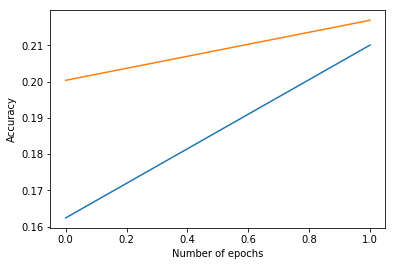

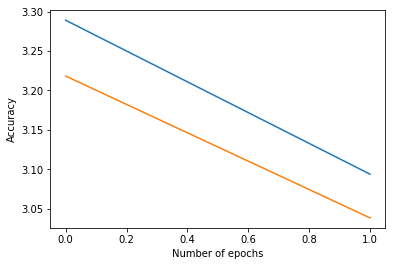

In [27]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.savefig('acc.pdf')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.savefig('loss.pdf')

### Max acc

In [23]:
print('Max val_acc: %.2f%%' % max(history.history['val_acc']))
print('Max acc: %.2f%%' % max(history.history['acc']))

Max val_acc: 0.22%
Max acc: 0.21%
